
<div align="center">

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dapivei/causal-infere/blob/main/sections/1-Introduction.ipynb)

</div>






# Introduction

![Causality](https://simons.berkeley.edu/sites/default/files/styles/hero_xxl_1x/public/2023-01/Causality_hi-res.jpg?h=6dcb57f1&itok=5R0Da6OT.png?raw=true)




## Goals for today

- Review of setup and tools for running code.
- Differentiate descriptive from causal questions.
- Introduce the all-causes model
- Identify and estimate causal parameters with simulated data.
---



## Review of setup and tools for running code.

+ Tutorial to install Python, available [here](https://realpython.com/installing-python/).

+ Tutorial to install Jupyter [here](https://jupyter.org/install).

+ Tutorial to work with NYU's High Performance Computing ([NYU HPC](https://sites.google.com/nyu.edu/nyu-hpc)).


+ Easiest way for now: [Google Colab](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj).



## The effect of class attendace on grades

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

A professor is on a mission to find out if attending classes regularly really gives students that extra grade boost. He's not just interested in *describing* what's happening he wants to figure out the *effect* of attendance on grades. **How do we go from simply observing grades to truly understanding *what causes* better performance?**


### Notation
Let $$Y_i(s, u)$$

represent the outcome of interest: grades for student $i$ under potential state $s$ and given all other factors $u$.
- **$s$**: A potential state of the world, such as regularly attending classes ($s = 1$) or attending irregularly ($s = 0$).
- **$u$**: All other factors that might influence grades, like study habits, prior knowledge, or motivation.



### Descriptive Analysis


Let us simulate grades based on a normal distribution. This allows us to later analyze how attendance impacts these grades.



In [2]:
# Setting a random seed for reproducibility
np.random.seed(42)

# Parameters
students = 1000
mean_grade = 75
std_grade = 12

<Axes: xlabel='Grade', ylabel='Density'>

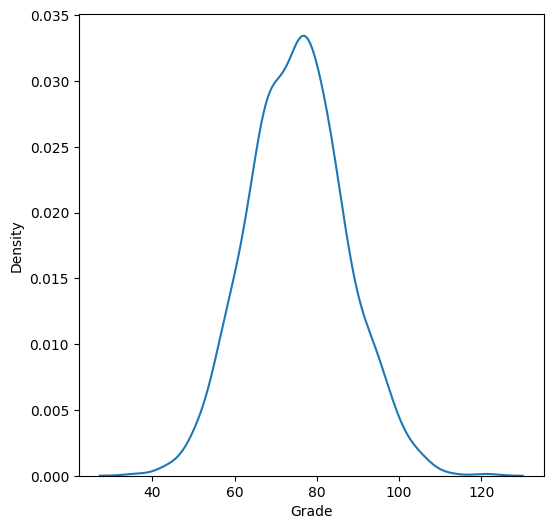

In [3]:
# Simulate attendance and grades
grades = np.random.normal(mean_grade, std_grade, students)
attendance = np.random.binomial(1, 0.6, students)
grades = pd.DataFrame({
    'Grade': grades,
    'Attendance': attendance
})

# Plot
plt.figure(figsize=(6, 6))
sns.kdeplot(grades['Grade'])


Let’s start by examining the current state of the world, focusing on a straightforward descriptive question: **What is the average grade in this course?** Notice, here we are not distinguishing between different attendance patterns — our goal is to simply describe the grades as they are:

- **_Current State ($s$):_** This represents the actual, observed state of the world where students have varied levels of attendance, but we are not yet separating them into “regular” or “irregular” attendance categories.
  
- **_Outcome ($Y_i(s, u)$):_** The grade $Y_i$ for student $i$ given their current attendance pattern $s$ and other influencing factors $u$.

To calculate the average grade, we observe:

\begin{aligned}
\mathbb{E}[Y] = \frac{1}{N} \sum_{i=1}^N Y_i(s, u)
\end{aligned}


where:
- $N: \text{is the nu ber of students.}$
- $s$ is the current attendance status for each student (which varies but is not yet isolated into specific patterns).
- $u$ includes other relevant factors like study habits, prior knowledge, and motivation.

In [4]:
grades.head(5)

,Grade,Attendance
0,80.960570,1
1,73.340828,1
2,82.772262,0
3,93.276358,0
4,72.190160,1


In [5]:
print(f"Average grade in the course is {grades['Grade'].mean():.2f}.")

Average grade in the course is 75.23.


**Can we now answer what is the effect of attendance on grades? Not yet! Why?** Even though we've got some insights from our descriptive analysis, there's a big issue we can't overlook: we're only seeing each student in **one attendance scenario** — either regular or irregular.

We have no idea what would happen to their grades if they switched their attendance pattern! This missing information —**the counterfactual**— is exactly what makes causal inference so tricky and it's known as **the fundamental problem of causal inference**.


### From Descriptive to Causal Analysis in a Perfect World (For Now)

Assumptions:

1. **Perfect Knowledge of Both States:** We can observe both regular $Y_i(1, u)$ and irregular attendance $Y_i(0, u)$ grades for every student — something that's impossible in the real world.
2. **No Confounding Factors:** Attendance is the only factor affecting grades, which may not be true in reality.
3. **Random Assignment:** Attendance can simulated as being randomly assigned, avoiding biases often seen in real-world settings.

Given our “perfect world”, **Average Treatment Effect (ATE)** is defined as:

$$
\text{ATE} = \mathbb{E}[Y_i(1, u)] - \mathbb{E}[Y_i(0, u)].
$$


In [6]:
# Simulations
attend_effect = 10
attendance = np.random.binomial(1, 0.5, students)
grades = grades['Grade']
grades_attend = grades + attendance * attend_effect
grades_nattend = grades

# Create DataFrame
attend = pd.DataFrame({
    'Student_ID': np.arange(1, students + 1),
    'Attendance': attendance,
    'Grade_With_Attendance': grades_attend,
    'Grade_Without_Attendance': grades_nattend
})


In [7]:
attend.head(5)

,Student_ID,Attendance,Grade_With_Attendance,Grade_Without_Attendance
0,1,0,80.960570,80.960570
1,2,0,73.340828,73.340828
2,3,0,82.772262,82.772262
3,4,0,93.276358,93.276358
4,5,1,82.190160,72.190160


In [8]:
attend.describe()

,Student_ID,Attendance,Grade_With_Attendance,Grade_Without_Attendance
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,0.492000,80.151985,75.231985
std,288.819436,0.500186,12.784578,11.750591
min,1.000000,0.000000,36.104792,36.104792
25%,250.750000,0.000000,71.533906,67.228916
50%,500.500000,0.000000,79.567349,75.303607
75%,750.250000,1.000000,88.905759,82.775327
max,1000.000000,1.000000,121.946570,121.232778


In [9]:
# Calculate average grades for each state
avg_reg = attend['Grade_With_Attendance'].mean()
avg_irr = attend['Grade_Without_Attendance'].mean()

# Calculate the causal effect
ate = avg_reg - avg_irr

# Output results
print(f"Average grade with regular attendance: {avg_reg:.2f}")
print(f"Average grade with irregular attendance: {avg_irr:.2f}")
print(f"Regular attendance improves grades by {ate:.2f} points.")



Average grade with regular attendance: 80.15
Average grade with irregular attendance: 75.23
Regular attendance improves grades by 4.92 points.


Text(1.15, 90.1519846698679, 'ATE: 4.92 points')

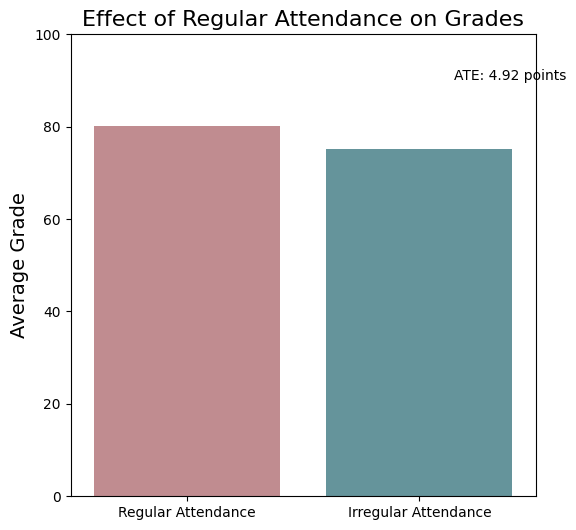

In [10]:
# Plotting
labels = ['Regular Attendance', 'Irregular Attendance']
values = [avg_reg, avg_irr]
plt.figure(figsize=(6, 6))
sns.barplot(
    x=labels, y=values, hue=labels, palette = ['#c98389','#5c9ba4'], legend=False
    )
plt.title('Effect of Regular Attendance on Grades', fontsize=16)
plt.ylabel('Average Grade', fontsize=14)
plt.ylim(0, 100)
plt.annotate(
    f'ATE: {ate:.2f} points', xy=(0.95, avg_reg), xytext=(1.15, avg_reg + 10)
    )


## Path Forward

1. Dive deeper into the assumptions we've made and understand how to relax or verify them.
2. Explore statistical methods to estimate causal effects in more complex, real-world data settings.
3. Investigate how to identify and handle confounding variables using techniques like matching, regression, and instrumental variables.

Moving from simple descriptive analysis to robust causal inference!
